In [175]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import powerlaw

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.clustering import TimeSeriesKMeans
from tslearn.svm import TimeSeriesSVC, TimeSeriesSVR

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

In [68]:
tdata = pd.read_csv("CleanTimeStampsDurationLabels.csv", names=["id", "Tag","Start","End","Duration"], skiprows=1)
print(tdata.shape)
print(tdata.head())

(161154, 5)
   id           Tag          Start            End  Duration
0   0  Jake Bentley  9/3/2017 0:00  9/3/2017 1:00         1
1   1      NC State  9/3/2017 0:00  9/3/2017 1:00         1
2   2       Broncos  9/3/2017 0:00  9/3/2017 1:00         1
3   3  Jim McElwain  9/3/2017 0:00  9/3/2017 1:00         1
4   4      Ty Isaac  9/3/2017 0:00  9/3/2017 1:00         1


In [69]:
wdata = pd.read_csv("wiki_timeseries_full.csv")
print(wdata.shape)
print(wdata.head())

(103951, 36)
   id      raw_topic                         i_topic                 date  \
0   0    John O'Korn                     John O'Korn  2017-09-03 00:00:00   
1   1       Harbaugh                    Jim Harbaugh  2017-09-03 00:00:00   
2   3     Tom Herman  Tom Herman (American football)  2017-09-03 00:00:00   
3   5  Justin Turner                   Justin Turner  2017-09-03 00:00:00   
4   6     Lance Lynn                      Lance Lynn  2017-09-03 00:00:00   

     t-15    t-14    t-13    t-12    t-11    t-10  ...     t+7     t+8  \
0    61.0    78.0    71.0    50.0    54.0    62.0  ...   268.0   116.0   
1  1077.0  1175.0  1339.0  1325.0  1141.0  1214.0  ...  5001.0  2922.0   
2   710.0   590.0   833.0   860.0   712.0   738.0  ...  2269.0   795.0   
3   869.0   520.0   601.0   897.0   872.0   635.0  ...   476.0   196.0   
4   204.0  1389.0   952.0   153.0   292.0   102.0  ...    51.0    40.0   

      t+9    t+10    t+11    t+12    t+13     t+14    t+15         mean  
0    

In [70]:
duration_counts = np.bincount(tdata["Duration"])
duration_list = np.arange(duration_counts.shape[0])

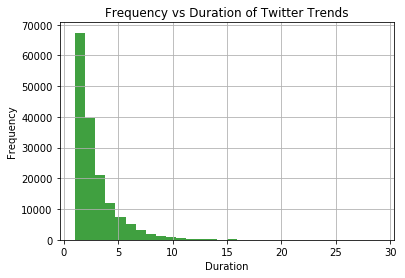

In [71]:
n, bins, patches = plt.hist(tdata["Duration"], bins=duration_counts.shape[0], facecolor='g', alpha=0.75)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Frequency vs Duration of Twitter Trends')
plt.grid(True)
plt.show()

Hmm, looks like it might follow a power law

C:\Users\Harrison\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


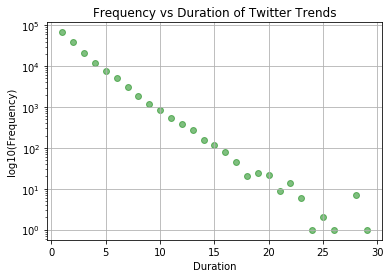

In [72]:
log_freq = np.log10(duration_counts)

masked_freq = np.ma.masked_where(duration_counts==0, duration_counts)
masked_duration_list = np.ma.masked_where(duration_counts==0, duration_list)

fig = plt.figure()
ax = plt.gca()
ax.scatter(masked_duration_list, masked_freq, c='g', alpha=0.5)
ax.set_yscale('log')
plt.xlabel('Duration')
plt.ylabel('log10(Frequency)')
plt.title('Frequency vs Duration of Twitter Trends')
plt.grid(True)
plt.show()

In [73]:
powerlaw_fit = powerlaw.Fit(duration_counts, discrete=True)
print(powerlaw_fit.power_law.alpha)
print(powerlaw_fit.power_law.xmin)
R, p = powerlaw_fit.distribution_compare('power_law', 'lognormal')
print(R)
print(p)

1.2382058774061746
6.0
-2.3541664194712975
0.1974352269344547


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\Harrison\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\Users\Harrison\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [212]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

C:\Users\Harrison\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


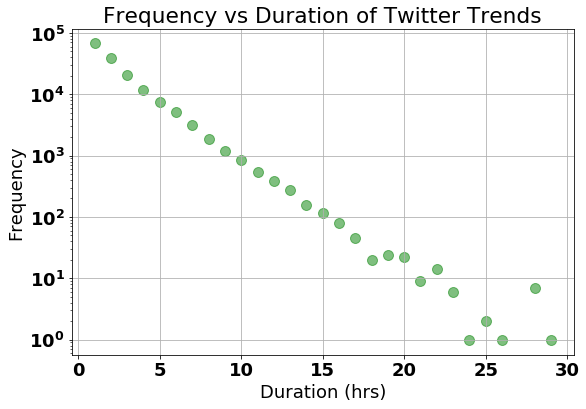

In [203]:
m, b = np.polyfit(masked_duration_list, np.log10(masked_freq), 1)

fig = plt.figure()
fig.set_size_inches(9, 6)
ax = plt.gca()
ax.scatter(masked_duration_list, masked_freq,s=100, c='g', alpha=0.5)
ax.set_yscale('log')
plt.xlabel('Duration (hrs)')
plt.ylabel('Frequency')
plt.title('Frequency vs Duration of Twitter Trends')
plt.grid(True)
plt.savefig('freq_dur.png', dpi=100)
plt.show()

Maybe pageviews follows a pattern too?

In [75]:
merged_data = wdata.merge(tdata, on=["id"],how='left')
print(merged_data.shape)
print(merged_data.head())

(103951, 40)
   id      raw_topic                         i_topic                 date  \
0   0    John O'Korn                     John O'Korn  2017-09-03 00:00:00   
1   1       Harbaugh                    Jim Harbaugh  2017-09-03 00:00:00   
2   3     Tom Herman  Tom Herman (American football)  2017-09-03 00:00:00   
3   5  Justin Turner                   Justin Turner  2017-09-03 00:00:00   
4   6     Lance Lynn                      Lance Lynn  2017-09-03 00:00:00   

     t-15    t-14    t-13    t-12    t-11    t-10  ...    t+11    t+12  \
0    61.0    78.0    71.0    50.0    54.0    62.0  ...    60.0    73.0   
1  1077.0  1175.0  1339.0  1325.0  1141.0  1214.0  ...  1978.0  1744.0   
2   710.0   590.0   833.0   860.0   712.0   738.0  ...   515.0   790.0   
3   869.0   520.0   601.0   897.0   872.0   635.0  ...   568.0   272.0   
4   204.0  1389.0   952.0   153.0   292.0   102.0  ...    80.0    71.0   

     t+13     t+14    t+15         mean              Tag          Start  \
0   

In [76]:
max_views = np.max(merged_data[["t-1", "t0", "t+1"]], axis=1)
median_views = np.nanmedian(merged_data[["t-1", "t0", "t+1"]], axis=1)

C:\Users\Harrison\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


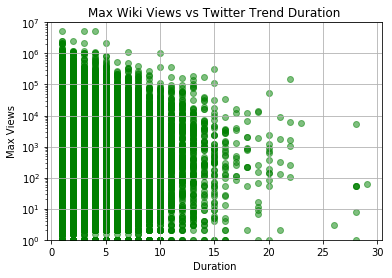

In [77]:

fig = plt.figure()
ax = plt.gca()
ax.scatter(merged_data["Duration"], max_views - median_views, c='g', alpha=0.5)
ax.set_yscale('log')
plt.xlabel('Duration')
plt.ylabel('Max Views')
plt.title('Max Wiki Views vs Twitter Trend Duration')
plt.grid(True)
ax.set_ylim([1,10**7])
plt.show()

In [78]:
merged_data = merged_data.dropna()
#print(merged_data.iloc[:,4:35])
avg_spike = np.zeros(duration_list.shape[0])
for i in range(duration_list.shape[0]):
    temp_df = merged_data[merged_data.Duration.isin([duration_list[i]])]
    max_mean = np.max(temp_df.iloc[:,4:35], axis = 1) - np.median(temp_df.iloc[:,4:35], axis = 1)
    avg_spike[i] = np.mean(max_mean)
print(avg_spike)

[           nan 19318.58269827 17221.65234596 17806.79591502
 19664.63437935 20311.26522528 15638.35564585 17432.48327606
 16815.88231917 15142.28520499 19412.46616541 15891.89018088
 17157.51075269 16502.64748201 12278.52054795 13715.46296296
  5196.08823529  9195.54545455  6231.33333333  5710.18181818
 28494.92307692  7572.         48976.          5783.
            nan            nan   655.                    nan
  2002.2          571.        ]


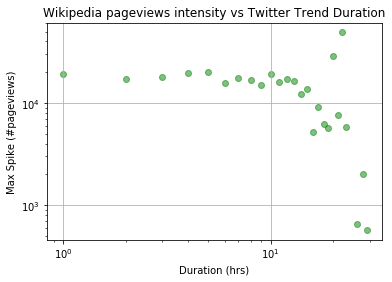

In [129]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(duration_list, avg_spike, c='g', alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Duration (hrs)')
plt.ylabel('Max Spike (#pageviews)')
plt.title('Wikipedia pageviews intensity vs Twitter Trend Duration')
plt.grid(True)
plt.show()

Try some algorithms from tslearn

In [80]:
ts_15 = merged_data.iloc[:,4:19]
print(ts_15.head())

     t-15    t-14    t-13    t-12    t-11    t-10     t-9     t-8     t-7  \
0    61.0    78.0    71.0    50.0    54.0    62.0    60.0    36.0    35.0   
1  1077.0  1175.0  1339.0  1325.0  1141.0  1214.0  1272.0  1124.0  1399.0   
2   710.0   590.0   833.0   860.0   712.0   738.0   685.0   887.0  1102.0   
3   869.0   520.0   601.0   897.0   872.0   635.0   383.0   732.0   598.0   
4   204.0  1389.0   952.0   153.0   292.0   102.0    88.0    62.0   252.0   

      t-6     t-5     t-4     t-3     t-2      t-1  
0   102.0   191.0    83.0    84.0   143.0   5339.0  
1  1983.0  2292.0  2682.0  2240.0  2530.0  14722.0  
2   733.0   872.0   825.0  1123.0  1957.0  18617.0  
3   296.0   245.0   577.0   453.0   182.0    669.0  
4    99.0    75.0   226.0   151.0   110.0    370.0  


In [81]:
ts_list = ts_15.values.tolist()
duration = merged_data["Duration"]

Scale the time series to mean=0, var=1

In [133]:
ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(ts_list)

In [142]:
print(merged_data.iloc[:, 1].values)

["John O'Korn" 'Harbaugh' 'Tom Herman' ... 'Rasmus Dahlin'
 'Orange is the New Black' 'Tom Hanks']


In [164]:
X_train, X_test, y_train, y_test = train_test_split(ts_scaled, duration, test_size=0.0, random_state=42)
print(X_train.shape)

(74837, 15, 1)


In [155]:
nc = 24
km = TimeSeriesKMeans(n_clusters=nc, verbose=True, random_state=42)
y_pred = km.fit_predict(X_train)
sz = X_train.shape[1]

9.194 --> 6.663 --> 6.406 --> 6.344 --> 6.320 --> 6.307 --> 6.296 --> 6.288 --> 6.282 --> 6.277 --> 6.273 --> 6.268 --> 6.263 --> 6.257 --> 6.252 --> 6.247 --> 6.243 --> 6.239 --> 6.237 --> 6.235 --> 6.233 --> 6.232 --> 6.231 --> 6.230 --> 6.230 --> 6.230 --> 6.229 --> 6.229 --> 6.228 --> 6.228 --> 6.228 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 6.227 --> 


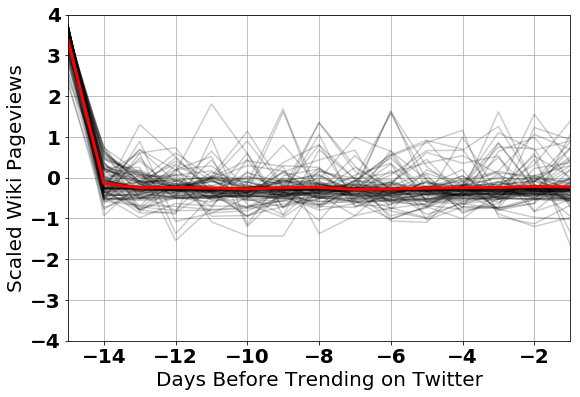

Terry Rozier        8
Rand Paul           8
Embiid              7
Jrue Holiday        7
Jordan Clarkson     7
Donovan Mitchell    6
Nick Young          6
Bartolo Colon       6
Kyle Anderson       6
Chris Webber        6
Name: raw_topic, dtype: int64


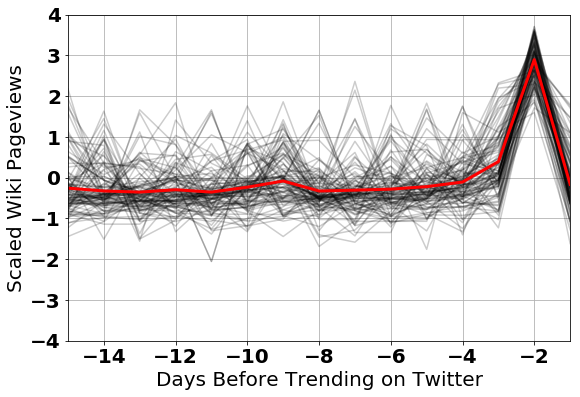

Dion Lewis       5
Josh Rosen       5
Kenley Jansen    4
Giannis          4
Lukaku           4
Mo Bamba         4
Chuck Todd       4
Asuka            4
Juve             4
Supreme Court    4
Name: raw_topic, dtype: int64


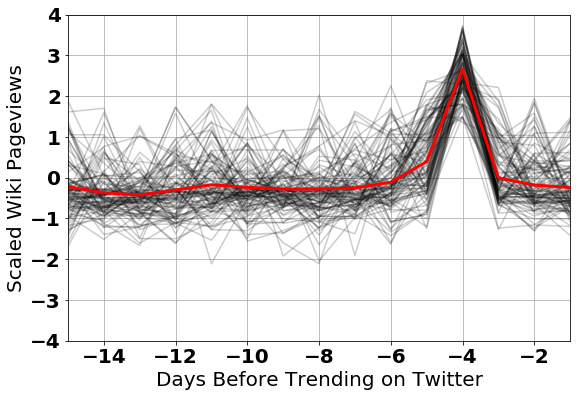

Nick Young           5
We're LIVE ON-AIR    5
Kawhi                5
Amber Alert          4
Andy Reid            4
Raymond Felton       4
Ryan Braun           4
Tyson Ross           3
Sarah Sanders        3
Clemson              3
Name: raw_topic, dtype: int64


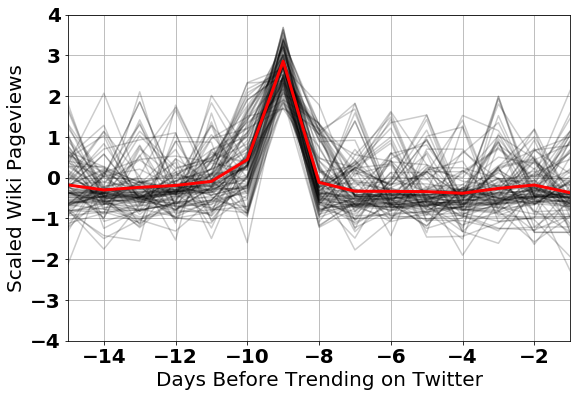

Marcus Smart    6
Kevin Knox      6
Xhaka           6
Clemson         6
George Hill     5
LeBron          5
Jeff Green      5
Oladipo         5
PJ Tucker       4
Race Day        4
Name: raw_topic, dtype: int64


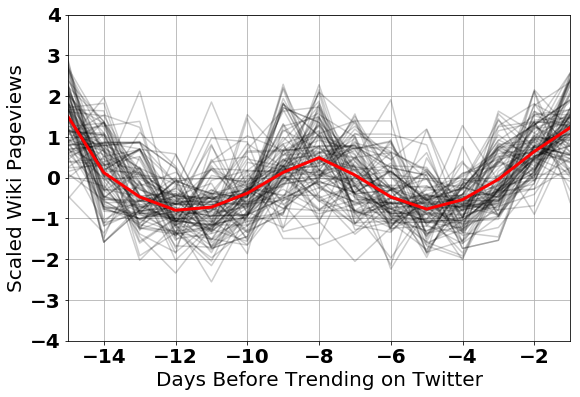

Championship Sunday    4
Rick Nash              4
LeBron                 4
Swaggy P               4
James Neal             3
Giroud                 3
Elias                  3
Tanner Roark           3
Rocket Man             3
Shaun Livingston       3
Name: raw_topic, dtype: int64


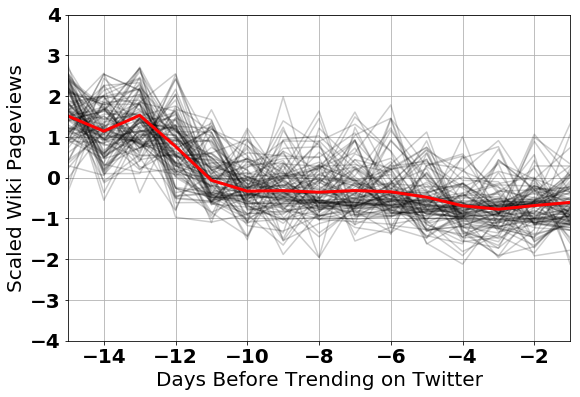

Eric Gordon       4
Cavs              4
Donald Glover     4
Holtby            4
Justin Wilson     4
De Gea            4
Jason Jordan      3
Steven Adams      3
Brad Hand         3
Marco Gonzales    3
Name: raw_topic, dtype: int64


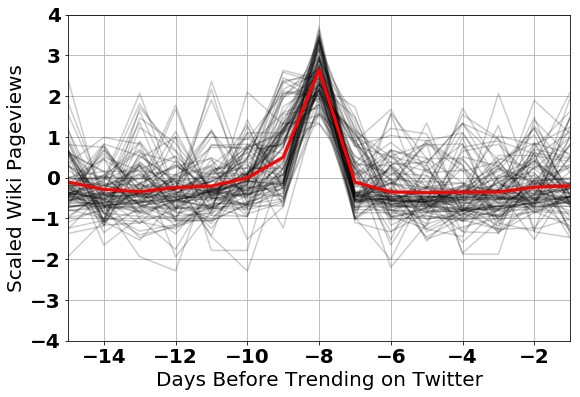

Jaylen Brown     6
Music Bank       5
Carlos Correa    5
Steven Wright    4
Jayson Tatum     4
Quinn Cook       4
Kirby Smart      4
Bill Maher       4
Lars Eller       4
Alex Smith       4
Name: raw_topic, dtype: int64


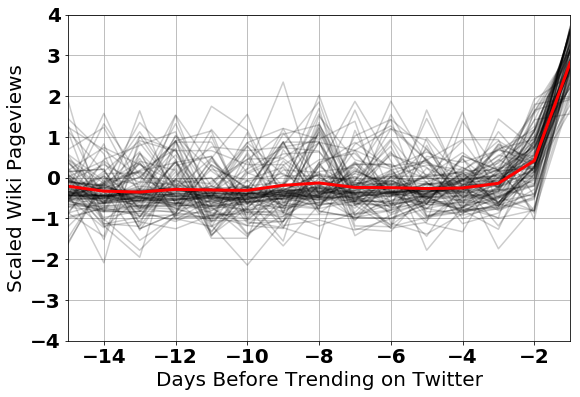

Chris Paul        6
Draymond Green    5
Pogba             5
Harry Kane        5
Rudy Gay          4
Honduras          4
Jake Arrieta      4
Jaylen Brown      4
Swaggy P          4
Brook Lopez       4
Name: raw_topic, dtype: int64


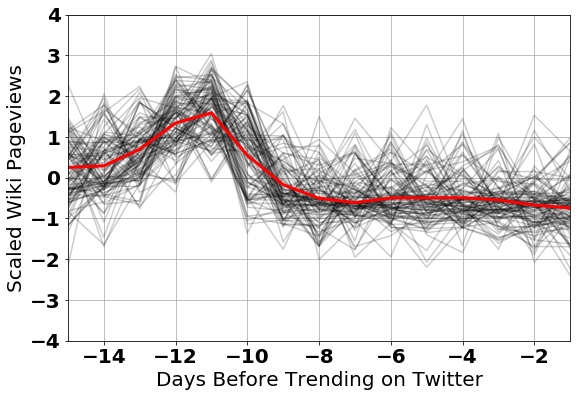

Capela             4
Yu Darvish         4
9th Circuit        3
Deion Sanders      3
Allen Hurns        3
Charles Barkley    3
Brook Lopez        3
West Ham           3
Xhaka              3
Tony Parker        3
Name: raw_topic, dtype: int64


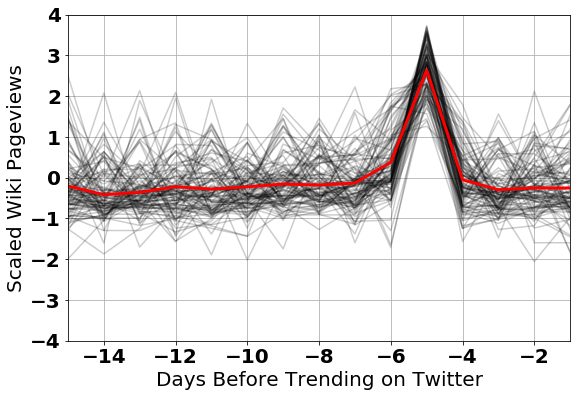

Steven Adams         5
We're LIVE ON-AIR    5
J.D. Martinez        4
Tom Wilson           4
Malcolm Butler       4
Joe Ingles           4
Rodney Hood          4
AP Poll              4
Fleury               4
Jon Gray             4
Name: raw_topic, dtype: int64


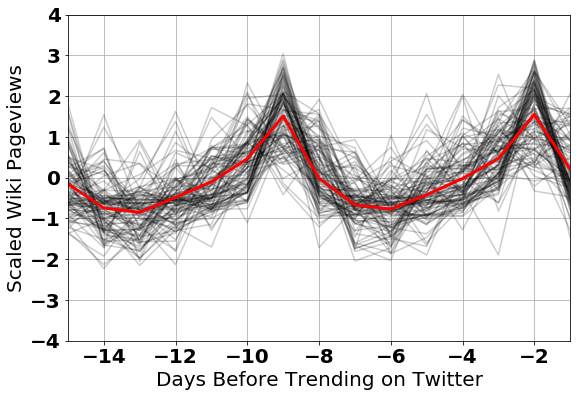

Hump Day          4
Chris Christie    4
LeBron            4
Matt Ryan         4
Bruce Pearl       4
Luis Severino     4
Kevin Hart        3
Cowboys           3
Iniesta           3
Preston Tucker    3
Name: raw_topic, dtype: int64


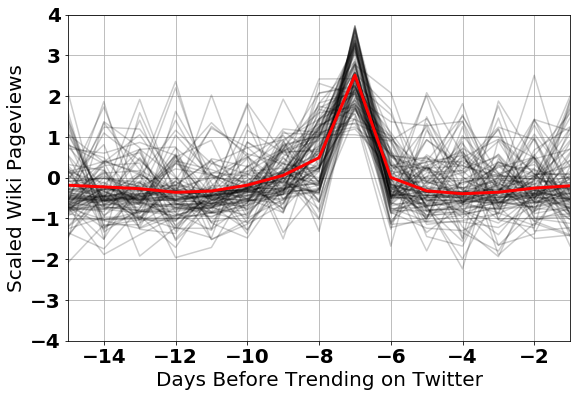

Nick Young          6
Lukaku              6
Tornado Watch       5
Patrice Bergeron    4
De'Aaron Fox        4
Vamos Mexico        4
Jrue Holiday        4
Mirotic             4
Clemson             4
Paul Pierce         4
Name: raw_topic, dtype: int64


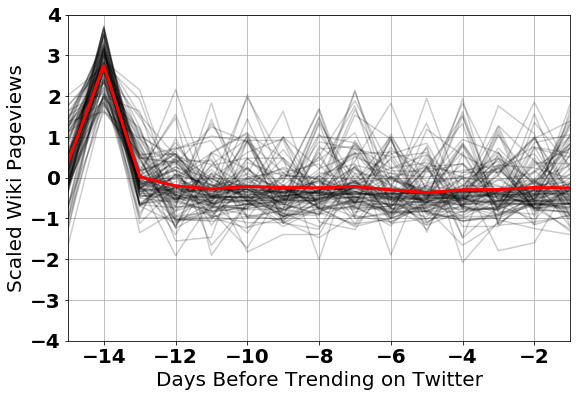

Hump Day           6
Clemson            5
JR Smith           4
Jaylen Brown       3
Josh Richardson    3
Wiggins            3
Nick Young         3
Klay               3
Nick Foles         3
PJ Tucker          3
Name: raw_topic, dtype: int64


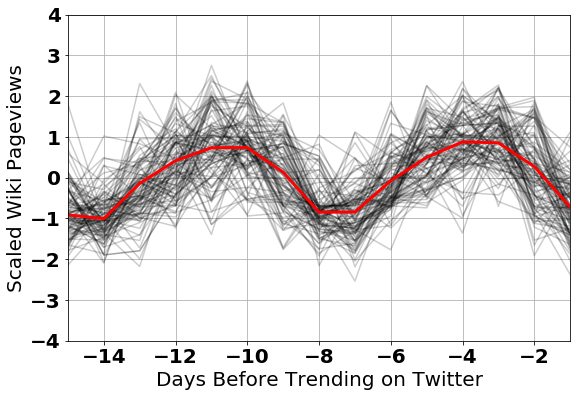

Donovan Mitchell       4
Championship Sunday    4
Tornado Watch          3
Klay                   3
Falcons                3
Avery Bradley          3
Jordan Bell            3
Davidson               3
Seth Rollins           3
Eric Gordon            3
Name: raw_topic, dtype: int64


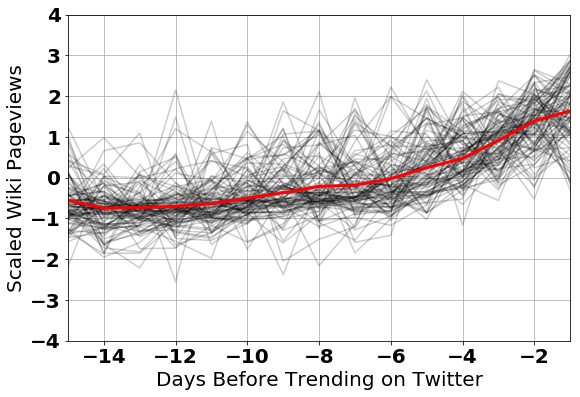

Marcus Smart           7
Amber Alert            4
Eric Gordon            4
Nick Young             4
Championship Sunday    4
Harry Kane             4
Pogba                  4
Samoa Joe              4
Ricky Rubio            4
John Carlson           3
Name: raw_topic, dtype: int64


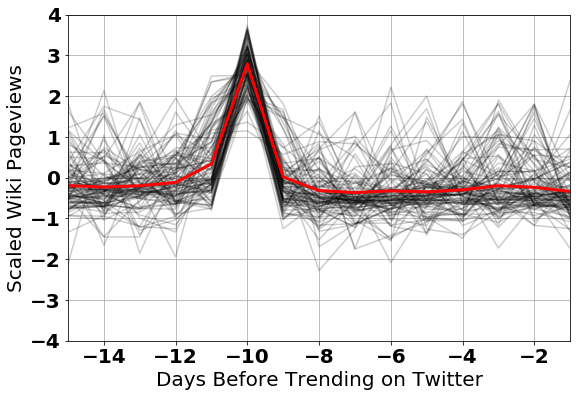

Jeff Green            6
Jimmy Graham          5
Terry Rozier          5
Bill Walton           5
Brayden Point         4
Alex Wood             4
Dense Fog Advisory    4
Jarred Vanderbilt     4
Gonzaga               4
Ben Simmons           4
Name: raw_topic, dtype: int64


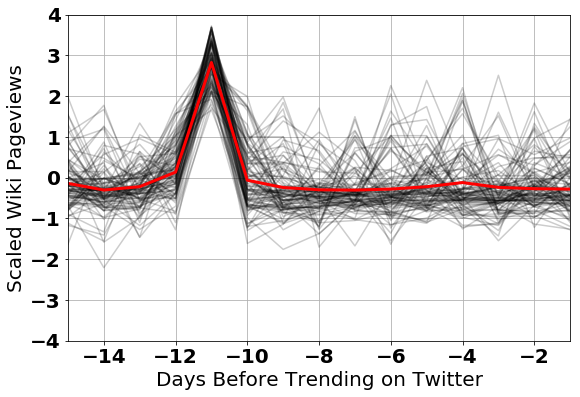

Hump Day        5
David West      5
George Hill     4
Jerami Grant    4
Gerald Green    4
De Gea          4
Luke Maye       4
Chiefs          4
Matt Murray     4
Eric Gordon     4
Name: raw_topic, dtype: int64


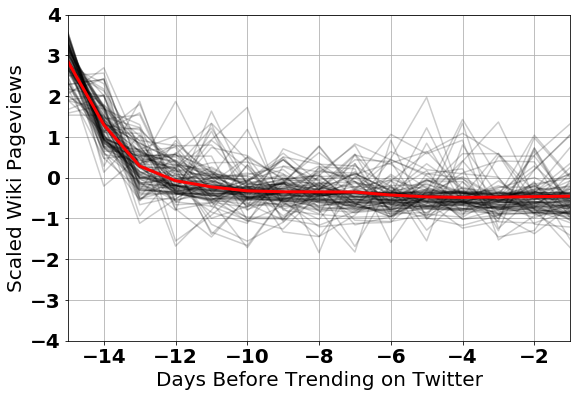

We're LIVE ON-AIR    11
Marcus Smart          6
Draymond              6
Tom Wilson            5
Chris Webber          5
Tyson Ross            5
Randle                5
Cristiano             4
Kevin Love            4
LaMarcus Aldridge     4
Name: raw_topic, dtype: int64


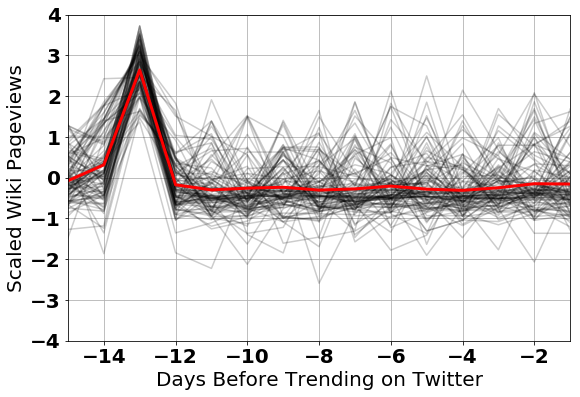

Harry Kane      5
Ronald Jones    5
Jordan Bell     4
Roberson        4
DACA            3
Elias           3
Matt Koch       3
Jayson Tatum    3
The Jazz        3
LeBron          3
Name: raw_topic, dtype: int64


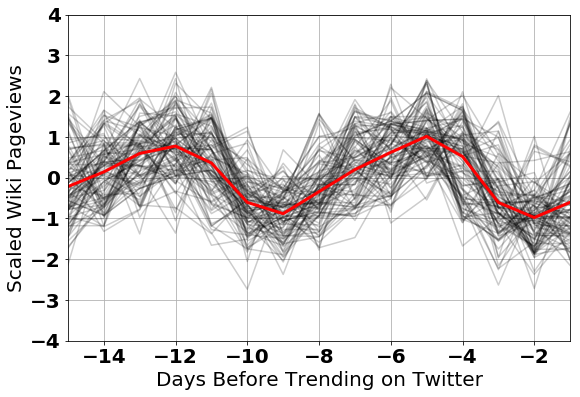

Bill Maher        4
Aron Baynes       3
Kevin Knox        3
Suarez            3
Marcelo           3
David West        3
John Oliver       3
Tom Arnold        3
Jerami Grant      2
Carsen Edwards    2
Name: raw_topic, dtype: int64


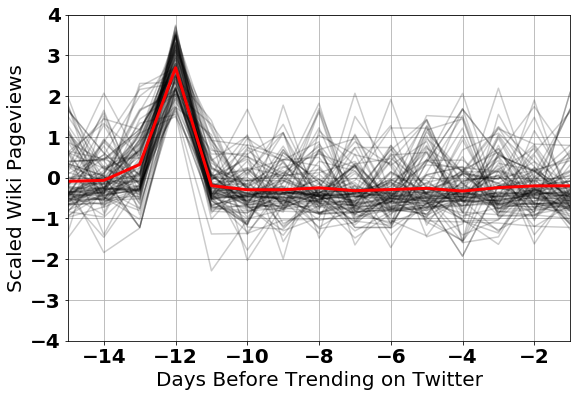

We're LIVE ON-AIR    5
Rashford             5
Celtics              4
JR Smith             4
Malik Newman         4
Marchand             4
Reggie Miller        4
Jeff Green           4
Todd Gurley          4
Ben McAdoo           3
Name: raw_topic, dtype: int64


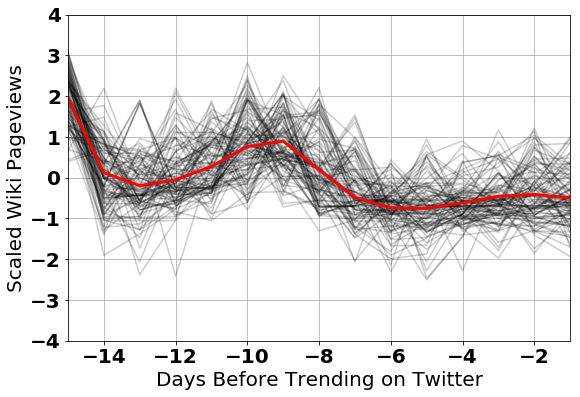

Travis Kelce      4
Saquon Barkley    4
Josh Hart         3
Draymond          3
Jabari Parker     3
David Price       3
Sean Hannity      3
Anthony Miller    3
Boogie            3
Will Grier        3
Name: raw_topic, dtype: int64


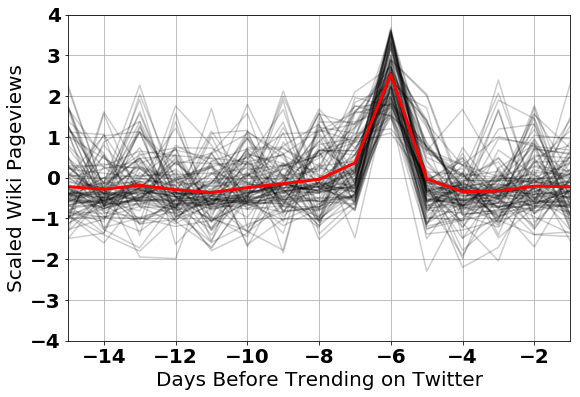

Joe Kelly        4
Bill Maher       4
Kyle Kuzma       4
Izzo             4
Miles Bridges    4
Tony Carr        4
Dwane Casey      4
Marcelo          4
Capela           4
Jack Flaherty    4
Name: raw_topic, dtype: int64


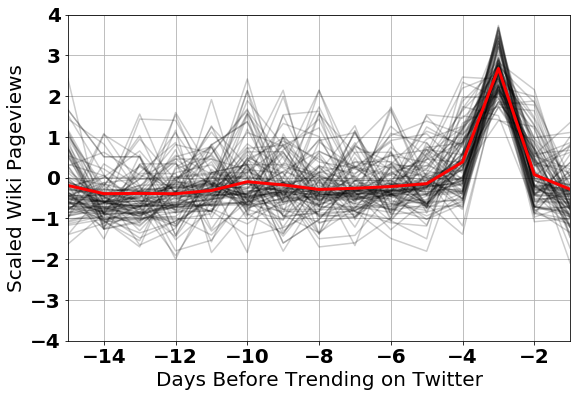

Gerald Green        5
David West          5
Jae Crowder         5
Jason Jordan        5
Larry Kudlow        4
Zach Collins        4
DeMarcus Cousins    4
Jevon Carter        4
Jay Bruce           4
Luke Maye           4
Name: raw_topic, dtype: int64


In [213]:
#plt.figure()

days_before = -1.*np.arange(15) -1
c = 0
for yi in range(nc):
    #plt.subplot(nc, 1, yi + 1)
    fig = plt.figure()
    fig.set_size_inches(9, 6)
    i = 0
    for xx in X_train[y_pred == yi]:
        i += 1
        plt.plot(days_before, xx.ravel(), "k-", alpha=.2)
        #Just show the first 100 for readability
        if i > 100:
            break
            
    mu = np.max(y_train[y_pred == yi])
    #print("Cluster max twitter duration: ", (mu))
    plt.plot(days_before, km.cluster_centers_[yi].ravel(), "r-", linewidth=3)
    plt.xlabel('Days Before Trending on Twitter')
    plt.ylabel('Scaled Wiki Pageviews')
    plt.xlim(-15, -1)
    plt.ylim(-4, 4)
    plt.grid(True)
    plt.savefig(fname, dpi=100)
    plt.show()
    
    df = merged_data.iloc[y_pred == yi, :]
    df = df['raw_topic'].value_counts()
    df = df.sort_values(ascending=False)
    print(df.head(10))
    fname = 'cluster_'+str(c)+'.png'
    c +=1
    
    #print(' '.join(merged_data.iloc[y_pred == yi, 1].tolist()))
    #wordcloud = WordCloud().generate(' '.join(merged_data.iloc[y_pred == yi, 1].tolist()))

    # Display the generated image:
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis("off")
#     plt.show()

In [222]:
X_train, X_test, y_train, y_test = train_test_split(ts_scaled[0:5000], duration[0:5000], test_size=0.25, random_state=42)

In [223]:
clf = TimeSeriesSVR(len(X_test[0]), 1, kernel='gak', gamma='auto')
clf.fit(X_train, y_train)

TimeSeriesSVR(C=1.0, cache_size=200, coef0=0.0, d=1, degree=3, epsilon=0.1,
       gamma='auto',
       kernel=<function _kernel_func_gak.<locals>.<lambda> at 0x000001F89D1601E0>,
       max_iter=-1, shrinking=True, sz=15, tol=0.001, verbose=False)

In [224]:
y_pred = clf.predict(X_test)

In [225]:
mean_squared_error(y_test, y_pred)

5.932483830700253

In [226]:
mean_absolute_error(y_test, y_pred)

1.4136852132430486